In [0]:
%matplotlib inline

In [2]:
! pip freeze

beautifulsoup4==4.6.0
bleach==1.5.0
cachetools==2.0.1
certifi==2018.1.18
chardet==3.0.4
crcmod==1.7
cycler==0.10.0
decorator==4.2.1
dill==0.2.7.1
entrypoints==0.2.3
enum34==1.1.6
future==0.15.2
futures==3.0.5
gapic-google-cloud-datastore-v1==0.15.3
gapic-google-cloud-error-reporting-v1beta1==0.15.3
gapic-google-cloud-logging-v2==0.91.3
google-api-core==0.1.4
google-api-python-client==1.6.5
google-auth==1.3.0
google-auth-httplib2==0.0.3
google-auth-oauthlib==0.2.0
google-cloud==0.32.0
google-cloud-bigquery==0.28.0
google-cloud-bigquery-datatransfer==0.1.0
google-cloud-bigtable==0.28.1
google-cloud-container==0.1.0
google-cloud-core==0.28.0
google-cloud-datastore==1.4.0
google-cloud-dns==0.28.0
google-cloud-error-reporting==0.28.0
google-cloud-firestore==0.28.0
google-cloud-language==1.0.0
google-cloud-logging==1.4.0
google-cloud-monitoring==0.28.0
google-cloud-pubsub==0.30.1
google-cloud-resource-manager==0.28.0
google-cloud-runtimeconfig==0.28.0
google-cloud-spanner==0.29.0
google-clou

In [3]:
! pip install http://download.pytorch.org/whl/cu80/torch-0.2.0.post3-cp36-cp36m-manylinux1_x86_64.whl

    9% |███                             | 44.0MB 1.2MB/s eta 0:06:16

    100% |████████████████████████████████| 486.7MB 3.6MB/s 


In [4]:
! pip install torchvision==0.1.8


Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [6]:
! wget -O hymenoptera_data.zip "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

--2018-01-28 07:23:08--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.237.180, 52.84.237.242, 52.84.237.139, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.237.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  12.2MB/s    in 5.2s    

2018-01-28 07:23:14 (8.75 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [7]:
! unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318


  inflating: hymenoptera_data/val/bees/2415414155_1916f03b42.jpg  
  inflating: hymenoptera_data/val/bees/2438480600_40a1249879.jpg  
  inflating: hymenoptera_data/val/bees/2444778727_4b781ac424.jpg  
  inflating: hymenoptera_data/val/bees/2457841282_7867f16639.jpg  
  inflating: hymenoptera_data/val/bees/2470492902_3572c90f75.jpg  
  inflating: hymenoptera_data/val/bees/2478216347_535c8fe6d7.jpg  
  inflating: hymenoptera_data/val/bees/2501530886_e20952b97d.jpg  
  inflating: hymenoptera_data/val/bees/2506114833_90a41c5267.jpg  
  inflating: hymenoptera_data/val/bees/2509402554_31821cb0b6.jpg  
  inflating: hymenoptera_data/val/bees/2525379273_dcb26a516d.jpg  
  inflating: hymenoptera_data/val/bees/26589803_5ba7000313.jpg  
  inflating: hymenoptera_data/val/bees/2668391343_45e272cd07.jpg  
  inflating: hymenoptera_data/val/bees/2670536155_c170f49cd0.jpg  
  inflating: hymenoptera_data/val/bees/2685605303_9eed79d59d.jpg  
  inflating: hymenoptera_data/val/bees/2702408468_d9ed795f4f.jp

In [8]:
! ls

datalab  hymenoptera_data  hymenoptera_data.zip


In [33]:
! ls hymenoptera_data/train/

ants  bees


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



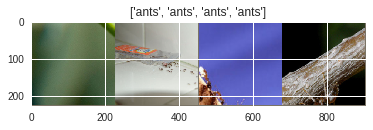

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6476 Acc: 0.6721
val Loss: 0.2137 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5990 Acc: 0.7869
val Loss: 0.2917 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.6367 Acc: 0.7746
val Loss: 0.3957 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.5374 Acc: 0.7500
val Loss: 0.2470 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.5501 Acc: 0.8074
val Loss: 0.5992 Acc: 0.7908

Epoch 5/24
----------
train Loss: 0.3839 Acc: 0.8607
val Loss: 0.2868 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.5873 Acc: 0.7992
val Loss: 0.2503 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4159 Acc: 0.8279
val Loss: 0.2055 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3120 Acc: 0.8689
val Loss: 0.2179 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3004 Acc: 0.8811
val Loss: 0.2241 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.2374 Acc: 0.8811
val Loss: 0.2224 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.2935 Acc: 0.8730
val Loss: 0.2171 Acc: 0.8889

Ep

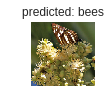

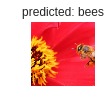

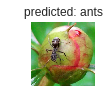

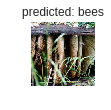

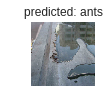

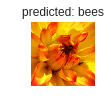

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8328 Acc: 0.6025
val Loss: 0.2742 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6237 Acc: 0.7377
val Loss: 0.3641 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.5141 Acc: 0.7664
val Loss: 0.2284 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3730 Acc: 0.8279
val Loss: 0.2645 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3956 Acc: 0.8238
val Loss: 0.1840 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.7366 Acc: 0.7172
val Loss: 0.3159 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6129 Acc: 0.7828
val Loss: 0.2528 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4056 Acc: 0.8443
val Loss: 0.2040 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3531 Acc: 0.8730
val Loss: 0.1983 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3344 Acc: 0.8484
val Loss: 0.1773 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2834 Acc: 0.8689
val Loss: 0.1804 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3587 Acc: 0.8279
val Loss: 0.1768 Acc: 0.9477

Ep

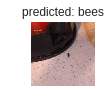

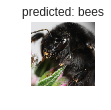

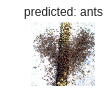

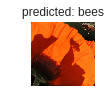

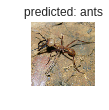

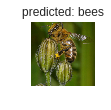

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## **Feature Representation By Manifold Learning **

We want to know what has been learnt for those images by ResNet.

One can also extract features from resnet18 and save it in .txt file for our explorations.

In this notebook we would like to take some feature representation examples by some popular methods such as PCA/MDS/tSNE

In [5]:
model_ft = models.resnet18(pretrained=True)
if use_gpu:
    model_ft=model_ft.cuda()
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


In [15]:
print(model_ft)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

Now extract 512-features as the network output after removing the last fc layer.

Getting all the features of the training data which will be used for Manifold Learning.

In [15]:
modules = list(model_ft.children())[:-1]
resnet18_feature = nn.Sequential(*modules)

dataloader_train=torch.utils.data.DataLoader(image_datasets['train'], batch_size=4,
                                             shuffle=False)

features=[]
classes=[]
for i,(images,labels) in enumerate(dataloader_train):
    img=Variable(images)
    if use_gpu:
        img=img.cuda()
    out=resnet18_feature.forward(img)
    features.append(out.view(4,512).cpu().data.numpy())
    classes.append(labels.numpy())
features=np.vstack(features)
classes=np.hstack(classes)

print('features size:{}\nlabels size:{}'.format(features.shape,classes.shape))

features size:(244, 512)
labels size:(244,)


Here, we compare 8 popular methods in Manifold Learning:

PCA,Isomap,MDA,tSNE,LLE,LTSA,Hessian LLE,Modified LLE

LLE starts......
LTSA starts......
Hessian LLE starts......
Modified LLE starts......
Isomap starts......
MDS starts......
TSNE starts......
PCA starts......


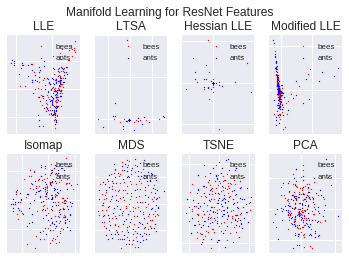

In [24]:
import seaborn
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap,MDS,TSNE,LocallyLinearEmbedding,SpectralEmbedding

LLE_dict=dict(zip(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE'],
                    ['standard', 'ltsa', 'hessian', 'modified']))
methods=['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','TSNE','PCA']

fig_features=plt.figure(1)
fig_features.suptitle('Manifold Learning for ResNet Features')

for i,method in enumerate(methods):
    print('{} starts......'.format(method))
    if method in LLE_dict.keys():
        manifold=LocallyLinearEmbedding(n_neighbors=6,method=LLE_dict[method],eigen_solver='dense')
    elif method=='MDS':
        manifold=MDS(n_init=1,max_iter=100)
    elif method=='PCA' or 'TSNE':
        exec('manifold={}(n_components=2)'.format(method))
    else:
        exec('manifold={}(n_neighbors=6)'.format(method))
    features_2D=manifold.fit_transform(features)
    np.save('features_2d_{}'.format(method),features_2D)
    
    ax=fig_features.add_subplot(241+i)
    ax.scatter(features_2D[np.where(classes==1),0],features_2D[np.where(classes==1),1],s=1,c='r',label='bees')
    ax.scatter(features_2D[np.where(classes==0),0],features_2D[np.where(classes==0),1],s=1,c='b',label='ants')
    ax.legend(loc='upper right',prop={'size':8})
    ax.set_title(method)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    
fig_features.savefig('Manifold_of_ResNet.png')


# **CNN layer Visualization**

Finally, we want to know what partten had been learnt in ResNet18 CNN layer.

In [25]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

Selecting previously unselected package libxext6:amd64.
(Reading database ... 16633 files and directories currently installed.)
Preparing to unpack .../libxext6_2%3a1.3.3-1_amd64.deb ...
Unpacking libxext6:amd64 (2:1.3.3-1) ...
Selecting previously unselected package x11-common.
Preparing to unpack .../x11-common_1%3a7.7+19ubuntu3_all.deb ...
Unpacking x11-common (1:7.7+19ubuntu3) ...
Selecting previously unselected package libice6:amd64.
Preparing to unpack .../libice6_2%3a1.0.9-2_amd64.deb ...
Unpacking libice6:amd64 (2:1.0.9-2) ...
Selecting previously unselected package libsm6:amd64.
Preparing to unpack .../libsm6_2%3a1.2.2-1_amd64.deb ...
Unpacking libsm6:amd64 (2:1.2.2-1) ...
Setting up libxext6:amd64 (2:1.3.3-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2) ...
Setting up x11-common (1:7.7+19ubuntu3) ...
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d 

In [0]:
import cv2

def preprocess_image(cv2im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): Image to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (Pytorch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # Resize image
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

In [0]:
def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    # Convert RBG to GBR
    recreated_im = recreated_im[..., ::-1]
    return recreated_im

In [0]:


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Generate a random image
        self.created_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Create the folder to export images if not exists
        if not os.path.exists('./generated'):
            os.makedirs('./generated')

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        self.processed_image = preprocess_image(self.created_image)
        # Define optimizer for the image
        # Earlier layers need higher learning rates to visualize whereas later layers need less
        optimizer = optim.SGD([self.processed_image], lr=100, weight_decay=1e-6)
        for i in range(1, 51):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = self.processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            if i%10==0:
                print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()[0]))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # Save image
            if i % 5 == 0:
                cv2.imwrite('./generated/layer_vis_l' + str(self.selected_layer) +
                            '_f' + str(self.selected_filter) + '_iter'+str(i)+'.jpg',
                            self.created_image)
        
        plt.grid(False)    
        plt.title('CNN layer :{} Visualization'.format(self.selected_layer))
        plt.imshow(self.created_image)
        plt.pause(0.01)
 

CNN layer:5
Iteration: 10 Loss: -0.27
Iteration: 20 Loss: -0.37
Iteration: 30 Loss: -0.43
Iteration: 40 Loss: -0.48
Iteration: 50 Loss: -0.51


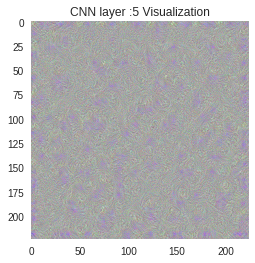

CNN layer:6
Iteration: 10 Loss: -1.87
Iteration: 20 Loss: -2.93
Iteration: 30 Loss: -3.54
Iteration: 40 Loss: -3.89
Iteration: 50 Loss: -4.18


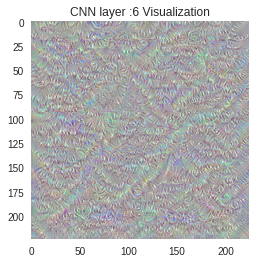

CNN layer:7
Iteration: 10 Loss: -27.29
Iteration: 20 Loss: -61.11
Iteration: 30 Loss: -85.24
Iteration: 40 Loss: -110.70
Iteration: 50 Loss: -130.74


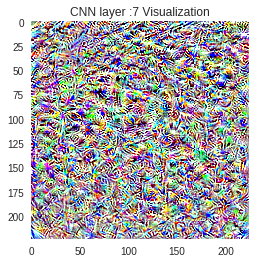

In [50]:
filter_pos = 0
for cnn_layer in [5,6,7]:
    print('CNN layer:{}'.format(cnn_layer))
    # Fully connected layer is not needed
    layer_vis = CNNLayerVisualization(resnet18_feature.cpu(), cnn_layer, filter_pos)

    # Layer visualization without pytorch hooks
    layer_vis.visualise_layer_without_hooks()
plt.ioff()
plt.show()